# Modeling Credit Risk with Lending Club data

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC


The biggest question re this data is which features are pulled at origination time.
For the details on this, see stuff below:
- https://www.kaggle.com/datasets/wordsforthewise/lending-club/discussion/220358
- https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook

From those links above, it seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

Notes:
Address is a key feature. Try to get it. Zip_code from address wil dramatically improve results.
And use ohe for more cat features.

### Business Problem

### Objective

### Summary of Results

In [77]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [79]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [80]:
time0 = time.time()

with open('../input/lc-800k-sample/LCLoans_141_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'total_rev_hi_lim',               
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd']

df = df[features_tokeep]


df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later
    
df = df.sample(200000)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(200000, 66)

1.3762321472167969

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd
0,Fully Paid,10000.0,10000.0,10000.0,36.0,5.31,301.109985,May-2018,credit_card,Credit card refinancing,w,Individual,A,A1,664.0,Investigator,5 years,MORTGAGE,52500.0,082xx,NJ,22.469999,Source Verified,5.0,NaN,NaN,80.0,NaN,NaN,2.0,Jun-2000,0.0,1.0,0.0,11.0,3.0,1.0,28.0,9554.0,105096.0,15862.0,82.6,2499.0,5.0,7.0,9.0,19200.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,105096.0,0.0,0.0,83.300003,100.000000,1.0,1.0,0.0,0.0,0.0,0.0
1,Current,5000.0,5000.0,5000.0,36.0,8.19,157.130005,Jan-2020,debt_consolidation,Debt consolidation,w,Joint App,A,A4,694.0,Art Director,6 years,MORTGAGE,100000.0,930xx,CA,12.340000,Not Verified,20.0,33.0,NaN,NaN,NaN,NaN,0.0,Feb-2000,0.0,0.0,0.0,5.0,1.0,7.0,15.0,73332.0,366658.0,12826.0,98.7,174.0,68.0,2.0,2.0,13000.0,0.0,0.0,0.0,0.0,0.0,220000.0,13.85,Not Verified,28123.0,0.0,0.0,100.000000,93.300003,0.0,0.0,0.0,0.0,0.0,0.0
2,Current,10000.0,10000.0,10000.0,60.0,14.71,236.380005,Aug-2020,debt_consolidation,Debt consolidation,f,Joint App,B,B3,769.0,Technician,< 1 year,RENT,31200.0,993xx,WA,44.139999,Verified,2.0,NaN,NaN,NaN,NaN,NaN,3.0,Aug-2014,1.0,2.0,2.0,16.0,7.0,0.0,25.0,1790.0,28635.0,5506.0,23.2,10082.0,2.0,6.0,14.0,23700.0,0.0,0.0,0.0,0.0,0.0,83872.0,24.65,Verified,28635.0,0.0,0.0,0.000000,100.000000,2.0,1.0,0.0,0.0,0.0,0.0
3,Fully Paid,4000.0,4000.0,4000.0,36.0,7.34,124.139999,May-2018,car,Car financing,f,Individual,A,A4,759.0,Banquet setup,1 year,RENT,12000.0,800xx,CO,5.000000,Verified,23.0,NaN,NaN,NaN,NaN,NaN,0.0,Apr-2014,0.0,0.0,0.0,3.0,1.0,0.0,5.0,84.0,251.0,251.0,1.0,24449.0,23.0,2.0,3.0,24700.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,251.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Fully Paid,10000.0,10000.0,10000.0,60.0,15.61,241.119995,Nov-2013,home_improvement,house improvement,f,Individual,C,C3,724.0,NaN,NaN,MORTGAGE,72000.0,656xx,MO,19.850000,Source Verified,2.0,36.0,64.0,NaN,64.0,36.0,4.0,Apr-1987,1.0,NaN,NaN,11.0,6.0,6.0,26.0,20408.0,204081.0,7109.0,42.8,9291.0,2.0,3.0,6.0,16600.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,38748.0,0.0,0.0,25.000000,84.599998,NaN,NaN,0.0,0.0,0.0,1.0


In [81]:
### feature description:

f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])


73    The number of open credit lines in the borrowe...
Name: desc, dtype: object

99    The total number of credit lines currently in ...
Name: desc, dtype: object

In [82]:
# clean time features

df.issue_d = df.issue_d.astype('O')
df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,Fully Paid,10000.0,10000.0,10000.0,36.0,5.31,301.109985,2018-05-01,credit_card,Credit card refinancing,w,Individual,A,A1,664.0,Investigator,5 years,MORTGAGE,52500.0,082xx,NJ,22.469999,Source Verified,5.0,NaN,NaN,80.0,NaN,NaN,2.0,2000-06-01,0.0,1.0,0.0,11.0,3.0,1.0,28.0,9554.0,105096.0,15862.0,82.6,2499.0,5.0,7.0,9.0,19200.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,105096.0,0.0,0.0,83.300003,100.000000,1.0,1.0,0.0,0.0,0.0,0.0,2018,5,2018,17.914126,0.055822
1,Current,5000.0,5000.0,5000.0,36.0,8.19,157.130005,2020-01-01,debt_consolidation,Debt consolidation,w,Joint App,A,A4,694.0,Art Director,6 years,MORTGAGE,100000.0,930xx,CA,12.340000,Not Verified,20.0,33.0,NaN,NaN,NaN,NaN,0.0,2000-02-01,0.0,0.0,0.0,5.0,1.0,7.0,15.0,73332.0,366658.0,12826.0,98.7,174.0,68.0,2.0,2.0,13000.0,0.0,0.0,0.0,0.0,0.0,220000.0,13.85,Not Verified,28123.0,0.0,0.0,100.000000,93.300003,0.0,0.0,0.0,0.0,0.0,0.0,2020,1,2020,19.915536,0.000000
2,Current,10000.0,10000.0,10000.0,60.0,14.71,236.380005,2020-08-01,debt_consolidation,Debt consolidation,f,Joint App,B,B3,769.0,Technician,< 1 year,RENT,31200.0,993xx,WA,44.139999,Verified,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2014-08-01,1.0,2.0,2.0,16.0,7.0,0.0,25.0,1790.0,28635.0,5506.0,23.2,10082.0,2.0,6.0,14.0,23700.0,0.0,0.0,0.0,0.0,0.0,83872.0,24.65,Verified,28635.0,0.0,0.0,0.000000,100.000000,2.0,1.0,0.0,0.0,0.0,0.0,2020,8,2020,6.001492,0.000000
3,Fully Paid,4000.0,4000.0,4000.0,36.0,7.34,124.139999,2018-05-01,car,Car financing,f,Individual,A,A4,759.0,Banquet setup,1 year,RENT,12000.0,800xx,CO,5.000000,Verified,23.0,NaN,NaN,NaN,NaN,NaN,0.0,2014-04-01,0.0,0.0,0.0,3.0,1.0,0.0,5.0,84.0,251.0,251.0,1.0,24449.0,23.0,2.0,3.0,24700.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,251.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018,5,2018,4.082219,0.000000
4,Fully Paid,10000.0,10000.0,10000.0,60.0,15.61,241.119995,2013-11-01,home_improvement,house improvement,f,Individual,C,C3,724.0,NaN,NaN,MORTGAGE,72000.0,656xx,MO,19.850000,Source Verified,2.0,36.0,64.0,NaN,64.0,36.0,4.0,1987-04-01,1.0,NaN,NaN,11.0,6.0,6.0,26.0,20408.0,204081.0,7109.0,42.8,9291.0,2.0,3.0,6.0,16600.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,38748.0,0.0,0.0,25.000000,84.599998,NaN,NaN,0.0,0.0,0.0,1.0,2013,11,2013,26.587815,0.000000


In [83]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             102622
Current                                                 70502
Charged Off                                             24559
Late (31-120 days)                                       1094
In Grace Period                                           687
Late (16-30 days)                                         178
Does not meet the credit policy. Status:Fully Paid        144
Issued                                                    139
Does not meet the credit policy. Status:Charged Off        47
Default                                                    28
Name: loan_status, dtype: int64

(127209, 72)

Fully Paid                                             102622
Charged Off                                             24559
Default                                                    28
Current                                                     0
Does not meet the credit policy. Status:Charged Off         0
Does not meet the credit policy. Status:Fully Paid          0
In Grace Period                                             0
Issued                                                      0
Late (16-30 days)                                           0
Late (31-120 days)                                          0
Name: loan_status, dtype: int64

loan_status                       127209
loan_amnt                         127209
funded_amnt                       127209
funded_amnt_inv                   127209
term                              127209
int_rate                          127209
installment                       127209
issue_d                           127209
purpose                           127209
title                             125774
initial_list_status               127209
application_type                  127209
grade                             127209
sub_grade                         127209
fico_range_high                   127209
emp_title                         118305
emp_length                        119251
home_ownership                    127209
annual_inc                        127209
zip_code                          127209
addr_state                        127209
dti                               127146
verification_status               127209
mo_sin_rcnt_tl                    122444
mths_since_last_

55.957777976989746

### Feature Preprocessing

In [84]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc
df['total_rev_inc'] = df.total_rev_hi_lim/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df.loc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    42061
2.0     11488
0.0     10432
3.0     10074
1.0      8458
5.0      7904
4.0      7613
6.0      5797
8.0      5388
7.0      5281
9.0      4755
Name: emp_length, dtype: int64

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,10000.0,10000.0,10000.0,36.0,5.31,301.109985,credit_card,Credit card refinancing,w,Individual,A,A1,664.0,Investigator,5.0,MORTGAGE,52500.0,82,NJ,22.469999,Source Verified,5.0,NaN,NaN,80.0,NaN,NaN,2.0,0.0,1.0,0.0,11.0,3.0,1.0,28.0,9554.0,105096.0,15862.0,82.6,2499.0,5.0,7.0,9.0,19200.0,0.0,0.0,0.0,1.0,1.0,105096.0,0.0,0.0,83.300003,100.000000,1.0,1.0,0.0,0.0,0.0,0.0,2018,5,2018,17.914126,0.055822,0.0,0.190476,0.068825,0,0.302133,0.181981,2.001829,2.001829,0.365714,0,0.392857,1
3,4000.0,4000.0,4000.0,36.0,7.34,124.139999,car,Car financing,f,Individual,A,A4,759.0,Banquet setup,1.0,RENT,12000.0,800,CO,5.000000,Verified,23.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3.0,1.0,0.0,5.0,84.0,251.0,251.0,1.0,24449.0,23.0,2.0,3.0,24700.0,0.0,0.0,0.0,0.0,0.0,251.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018,5,2018,4.082219,0.000000,0.0,0.333333,0.124140,0,0.020917,0.007000,0.020917,0.020917,2.058333,0,0.600000,0
4,10000.0,10000.0,10000.0,60.0,15.61,241.119995,home_improvement,house improvement,f,Individual,C,C3,724.0,NaN,NaN,MORTGAGE,72000.0,656,MO,19.850000,Source Verified,2.0,36.0,64.0,NaN,64.0,36.0,4.0,1.0,NaN,NaN,11.0,6.0,6.0,26.0,20408.0,204081.0,7109.0,42.8,9291.0,2.0,3.0,6.0,16600.0,0.0,0.0,0.0,0.0,0.0,38748.0,0.0,0.0,25.000000,84.599998,NaN,NaN,0.0,0.0,0.0,1.0,2013,11,2013,26.587815,0.000000,0.0,0.138889,0.040187,0,0.098736,0.283444,2.834458,0.538167,0.230556,0,0.423077,0
5,15000.0,15000.0,15000.0,36.0,9.80,482.609985,debt_consolidation,Debt consolidation,w,Joint App,B,B3,694.0,NaN,NaN,RENT,47000.0,335,FL,36.009998,Not Verified,4.0,NaN,NaN,70.0,NaN,NaN,1.0,0.0,0.0,1.0,13.0,4.0,2.0,37.0,4824.0,57890.0,14047.0,38.2,19369.0,4.0,7.0,11.0,36800.0,0.0,0.0,0.0,1.0,1.0,57890.0,0.0,0.0,25.000000,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,2016,1,2016,29.585823,0.033800,0.0,0.319149,0.123220,1,0.298872,0.102638,1.231702,1.231702,0.782979,0,0.351351,1
6,12000.0,12000.0,12000.0,36.0,12.74,402.829987,credit_card,Credit card refinancing,w,Individual,C,C1,679.0,Manager,2.0,OWN,65000.0,441,OH,32.959999,Not Verified,1.0,15.0,41.0,NaN,NaN,NaN,1.0,2.0,1.0,3.0,17.0,2.0,0.0,32.0,5205.0,88486.0,50790.0,85.9,1836.0,1.0,9.0,11.0,59100.0,1.0,0.0,0.0,0.0,0.0,88486.0,25.0,0.0,75.000000,84.400002,1.0,0.0,0.0,0.0,0.0,0.0,2016,11,2016,13.169333,0.000000,0.0,0.184615,0.074369,0,0.781385,0.080077,1.361323,1.361323,0.909231,0,0.531250,0


In [85]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



loan_amnt                         127209
funded_amnt                       127209
funded_amnt_inv                   127209
term                              127209
int_rate                          127209
installment                       127209
purpose                           127209
title                             125774
initial_list_status               127209
application_type                  127209
grade                             127209
sub_grade                         127209
fico_range_high                   127209
emp_title                         118305
emp_length                        119251
home_ownership                    127209
annual_inc                        127209
zip_code                          127209
addr_state                        127209
dti                               127146
verification_status               127209
mo_sin_rcnt_tl                    127209
mths_since_last_delinq            127209
mths_since_last_major_derog       127209
mths_since_last_

In [86]:
df.mo_sin_rcnt_tl.describe()

count    127209.000000
mean         12.206998
std          22.974876
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         272.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [87]:
df.verification_status.value_counts()

Source Verified    49896
Not Verified       40375
Verified           36938
Name: verification_status, dtype: int64

In [88]:
df.target.mean()

0.19328034966079444

In [89]:
cat_features_te = ['sub_grade', 'emp_title', 'purpose', 'title', 'zip_code', 'addr_state']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type', 'grade', 'home_ownership']

In [90]:
df.application_type.value_counts()

Individual    122468
Joint App       4741
Name: application_type, dtype: int64

### EDA

In [91]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,127209.000000,127209.000000,127209.000000
mean,14594.798828,14589.048828,14571.343750
std,8995.148438,8992.814453,8994.548828
min,1000.000000,1000.000000,0.000000
25%,7800.000000,7800.000000,7750.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    95099
60.0    32110
Name: term, dtype: int64

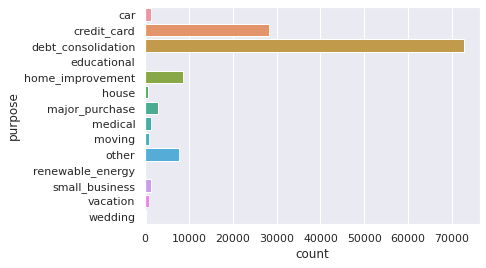

<AxesSubplot:xlabel='count', ylabel='emp_length'>

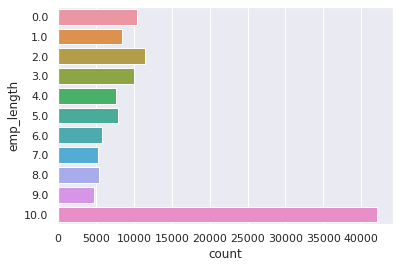

In [92]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [93]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [94]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    24587.000000
mean         0.343027
std          0.926637
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         19.000000
Name: delinq_2yrs, dtype: float64

count    102622.000000
mean          0.305432
std           0.847560
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          24.000000
Name: delinq_2yrs, dtype: float64

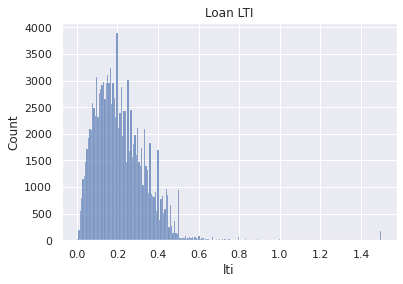

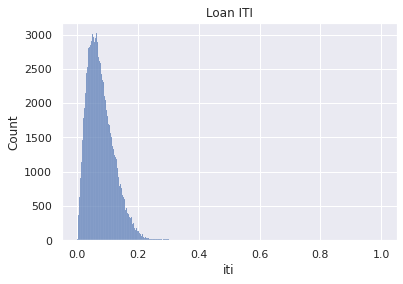

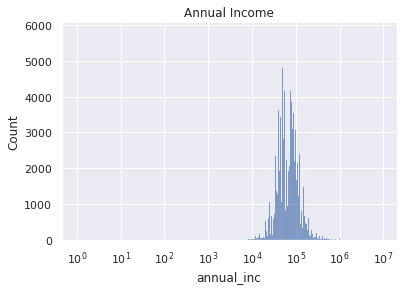

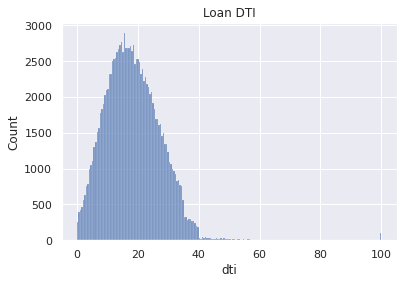

In [95]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()

In [96]:
df.dti.describe()

count    127146.000000
mean         18.445103
std           9.325068
min           0.000000
25%          11.820000
50%          17.709999
75%          24.290001
max         100.000000
Name: dti, dtype: float64

[Text(0.5, 1.0, 'Loan Grade')]

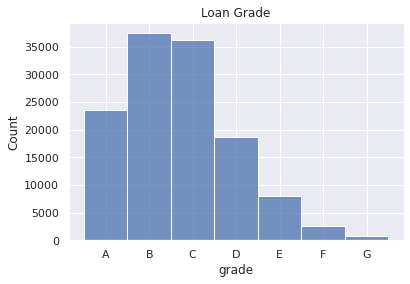

In [97]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')

### EDA with target

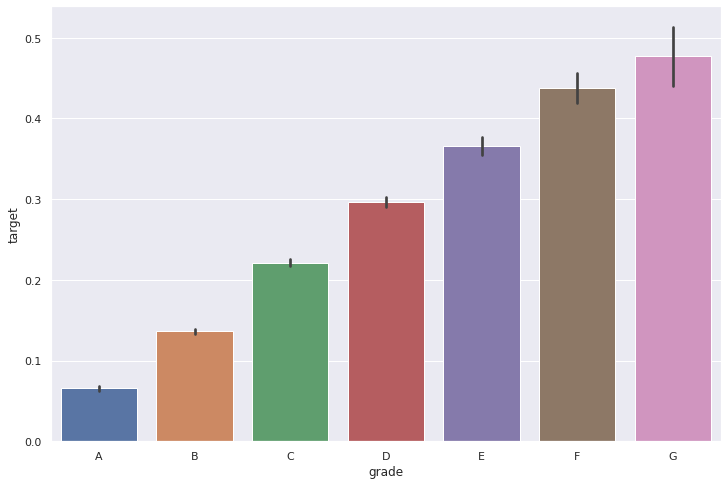

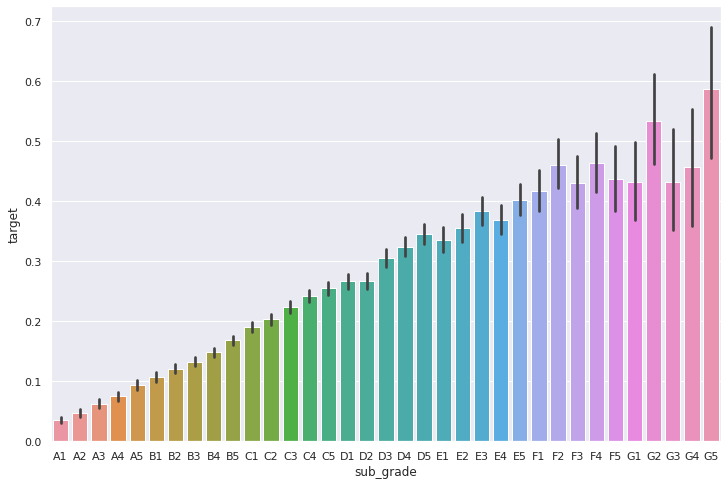

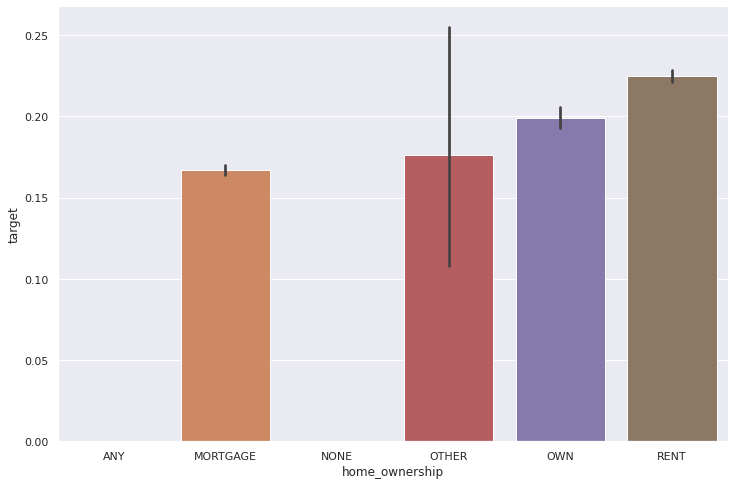

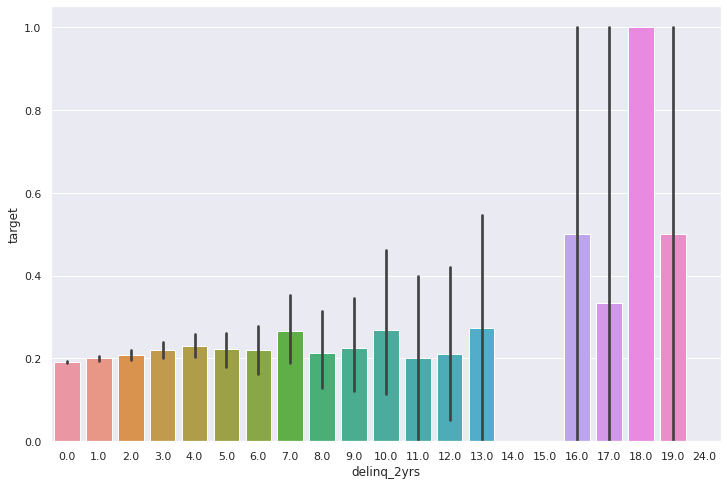

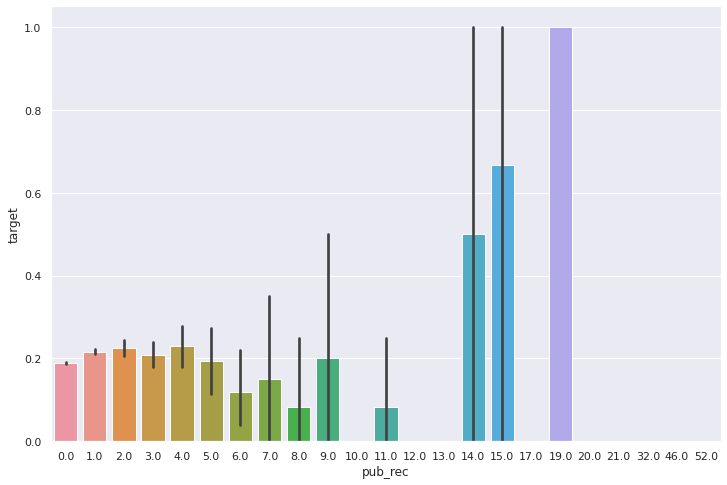

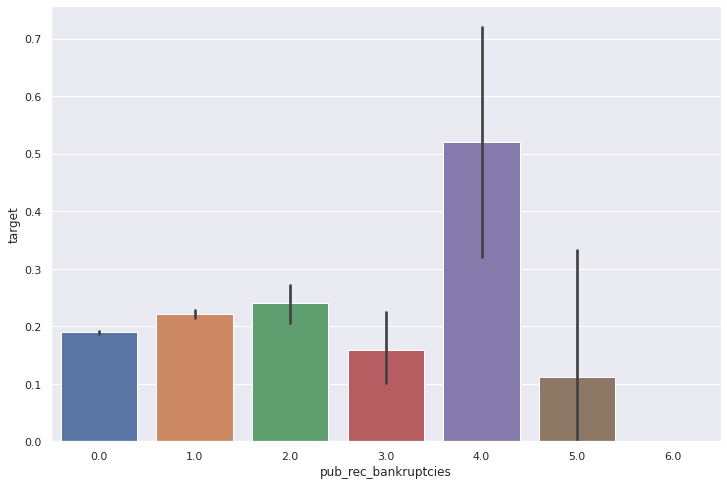

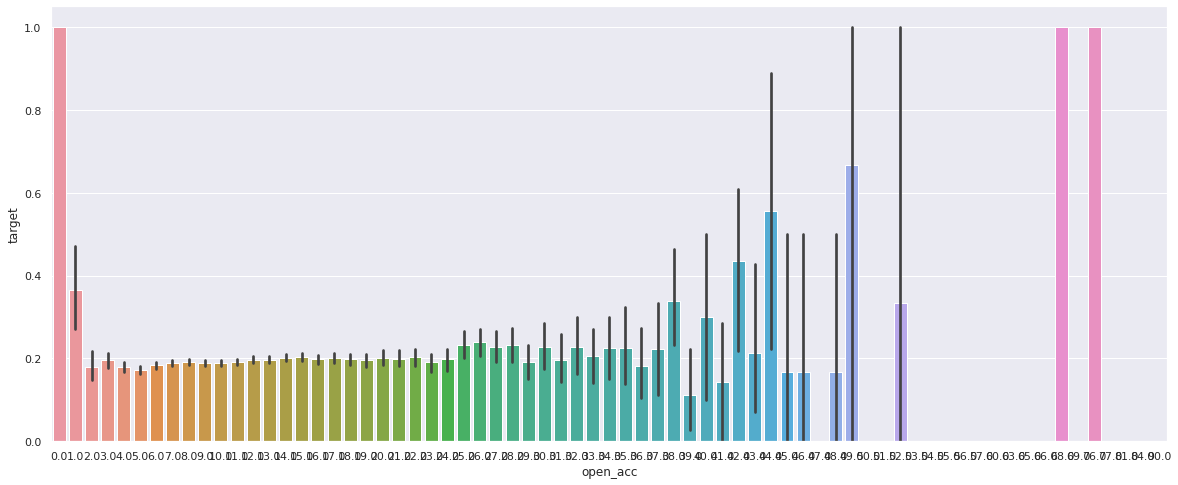

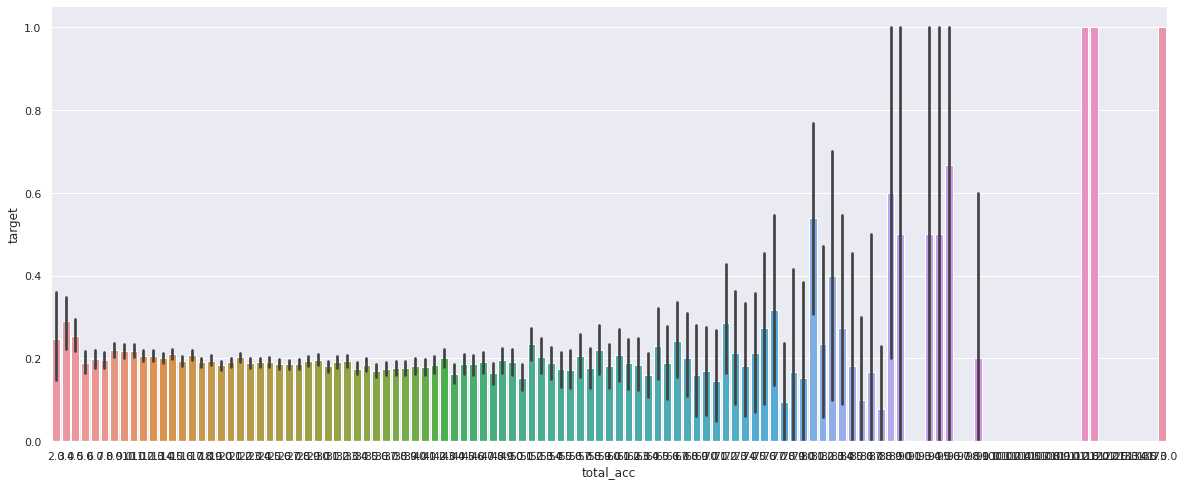

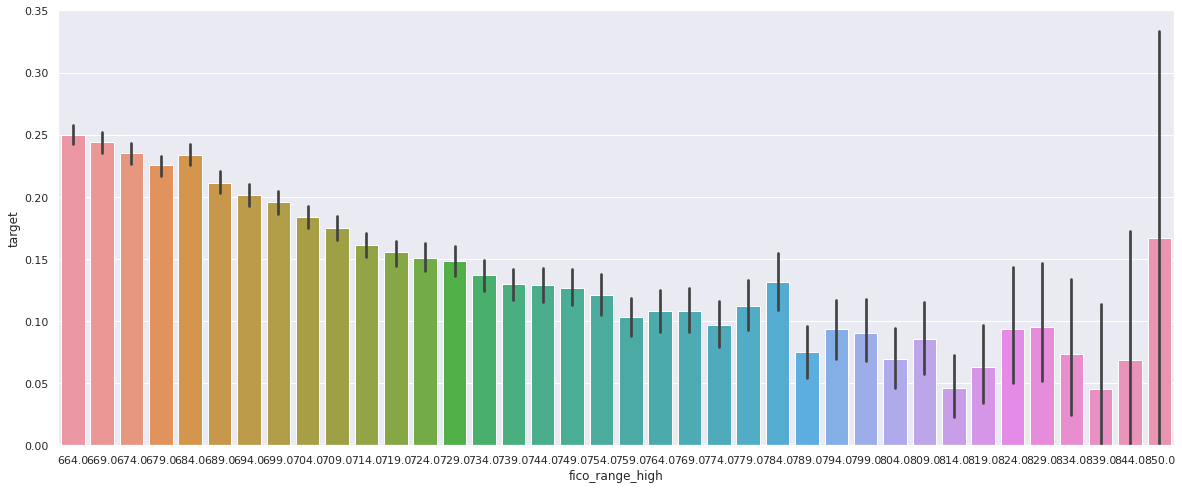

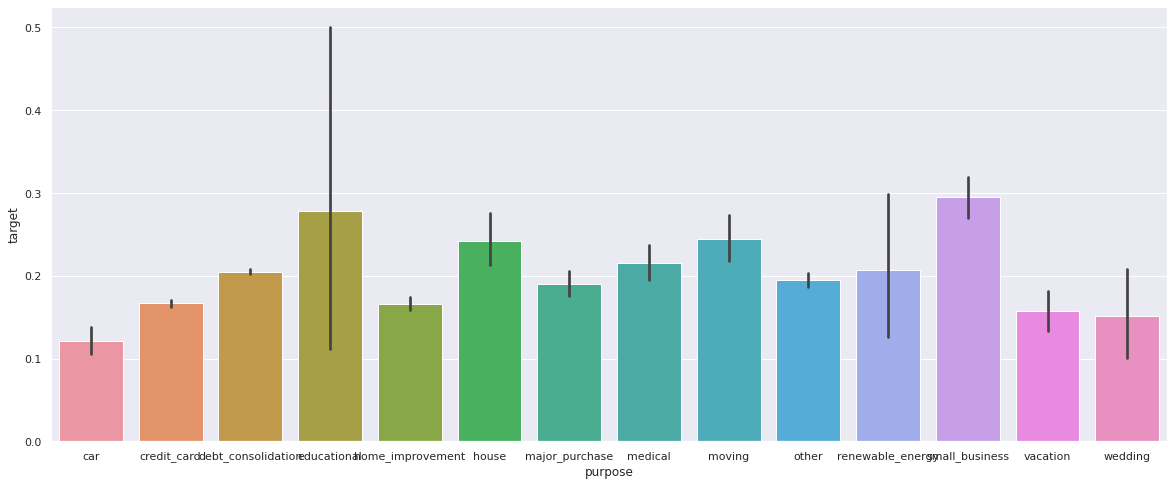

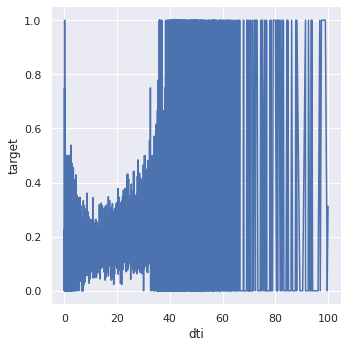

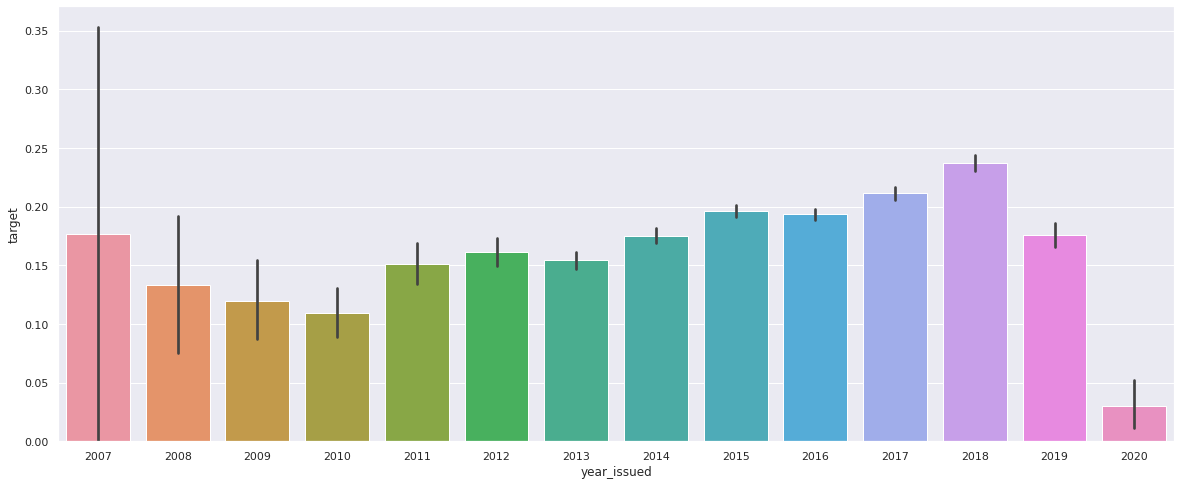

In [98]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.relplot(x='dti', y='target', data=df, ci=None, kind = 'line')
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

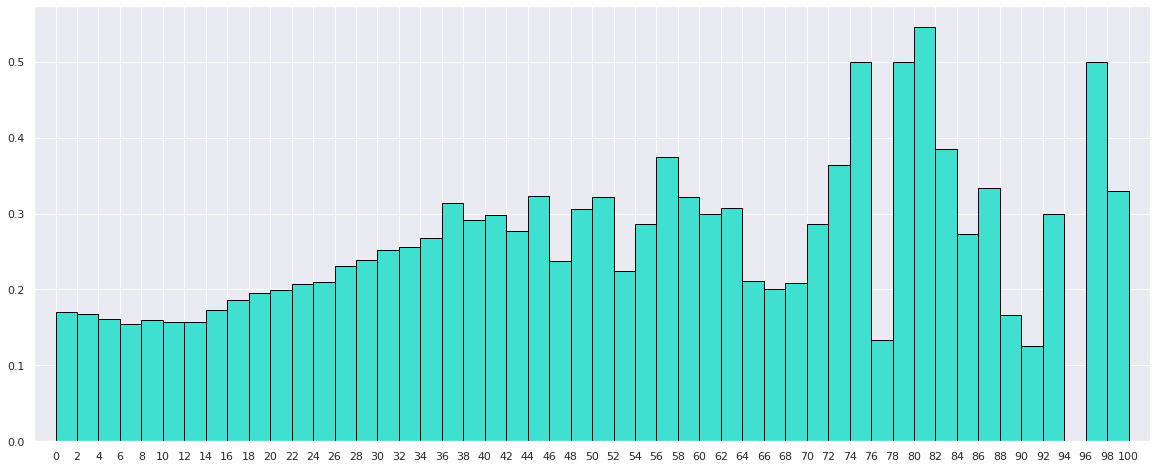

In [99]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) # 10 bins, so 11 bin boundaries
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

### Train-test split, missing values

In [100]:
display(df.count())

loan_amnt                         127209
funded_amnt                       127209
funded_amnt_inv                   127209
term                              127209
int_rate                          127209
installment                       127209
purpose                           127209
title                             125774
initial_list_status               127209
application_type                  127209
grade                             127209
sub_grade                         127209
fico_range_high                   127209
emp_title                         118305
emp_length                        119251
home_ownership                    127209
annual_inc                        127209
zip_code                          127209
addr_state                        127209
dti                               127146
verification_status               127209
mo_sin_rcnt_tl                    127209
mths_since_last_delinq            127209
mths_since_last_major_derog       127209
mths_since_last_

In [101]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
features_fill_zero = ['open_rv_12m', 'open_il_12m', 'emp_length', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m']

for col in features_fill_zero:
    df[col] = df[col].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(114489, 77)

(12720, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,10000.0,10000.0,10000.0,36.0,5.31,301.109985,credit_card,Credit card refinancing,w,Individual,A,A1,664.0,Investigator,5.0,MORTGAGE,52500.0,82,NJ,22.469999,Source Verified,5.0,1200.0,1200.0,80.0,1200.0,1200.0,2.0,0.0,1.0,0.0,11.0,3.0,1.0,28.0,9554.0,105096.0,15862.0,82.6,2499.0,5.0,7.0,9.0,19200.0,0.0,0.0,0.0,1.0,1.0,105096.0,0.0,0.0,83.300003,100.000000,1.0,1.0,0.0,0.0,0.0,0.0,2018,5,2018,17.914126,0.055822,0.0,0.190476,0.068825,0,0.302133,0.181981,2.001829,2.001829,0.365714,0,0.392857,1
1,4000.0,4000.0,4000.0,36.0,7.34,124.139999,car,Car financing,f,Individual,A,A4,759.0,Banquet setup,1.0,RENT,12000.0,800,CO,5.000000,Verified,23.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,5.0,84.0,251.0,251.0,1.0,24449.0,23.0,2.0,3.0,24700.0,0.0,0.0,0.0,0.0,0.0,251.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018,5,2018,4.082219,0.000000,0.0,0.333333,0.124140,0,0.020917,0.007000,0.020917,0.020917,2.058333,0,0.600000,0
2,10000.0,10000.0,10000.0,60.0,15.61,241.119995,home_improvement,house improvement,f,Individual,C,C3,724.0,MISSING,0.0,MORTGAGE,72000.0,656,MO,19.850000,Source Verified,2.0,36.0,64.0,1200.0,64.0,36.0,4.0,1.0,0.0,0.0,11.0,6.0,6.0,26.0,20408.0,204081.0,7109.0,42.8,9291.0,2.0,3.0,6.0,16600.0,0.0,0.0,0.0,0.0,0.0,38748.0,0.0,0.0,25.000000,84.599998,0.0,0.0,0.0,0.0,0.0,1.0,2013,11,2013,26.587815,0.000000,0.0,0.138889,0.040187,0,0.098736,0.283444,2.834458,0.538167,0.230556,0,0.423077,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,24000.0,24000.0,24000.0,60.0,15.31,574.880005,debt_consolidation,Debt consolidation,w,Individual,C,C5,714.0,Wealth Management Advisor,5.0,OWN,180000.0,115,NY,33.209999,Source Verified,8.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,1.0,3.0,3.0,19.0,8.0,1.0,38.0,8245.0,148412.0,52962.0,63.4,17840.0,17.0,9.0,13.0,83600.0,0.0,0.0,0.0,0.0,0.0,148412.0,0.0,0.0,37.500000,100.0,0.0,3.0,0.0,0.0,0.0,0.0,2016,2,2016,24.337255,0.0,0.0,0.133333,0.038325,0,0.294233,0.045806,0.824511,0.824511,0.464444,0,0.500,0
1,22475.0,22475.0,22475.0,60.0,19.52,589.469971,credit_card,Credit card refinancing,f,Individual,E,E3,719.0,Field Supervisor,3.0,MORTGAGE,85000.0,352,AL,36.740002,Source Verified,2.0,42.0,1200.0,1200.0,1200.0,1200.0,5.0,1.0,0.0,0.0,21.0,8.0,5.0,50.0,14114.0,296388.0,48253.0,53.0,35426.0,2.0,13.0,17.0,108100.0,0.0,0.0,0.0,0.0,0.0,93221.0,0.0,0.0,33.299999,98.0,0.0,0.0,0.0,0.0,0.0,0.0,2015,4,2015,33.498292,0.0,0.0,0.264412,0.083219,0,0.567682,0.166047,3.486918,1.096718,1.271765,0,0.420,0
2,13425.0,13425.0,13425.0,36.0,9.16,427.920013,credit_card,Credit card refinancing,w,Individual,B,B2,709.0,Jockey driver,2.0,RENT,40000.0,173,PA,12.750000,Not Verified,44.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,8.0,571.0,2855.0,2809.0,31.6,2927.0,44.0,3.0,4.0,8900.0,0.0,0.0,0.0,0.0,0.0,2855.0,190.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,4,2016,11.414334,0.0,0.0,0.335625,0.128376,0,0.070225,0.014275,0.071375,0.071375,0.222500,0,0.625,0


loan_amnt                         114489
funded_amnt                       114489
funded_amnt_inv                   114489
term                              114489
int_rate                          114489
installment                       114489
purpose                           114489
title                             114489
initial_list_status               114489
application_type                  114489
grade                             114489
sub_grade                         114489
fico_range_high                   114489
emp_title                         114489
emp_length                        114489
home_ownership                    114489
annual_inc                        114489
zip_code                          114489
addr_state                        114489
dti                               114489
verification_status               114489
mo_sin_rcnt_tl                    114489
mths_since_last_delinq            114489
mths_since_last_major_derog       114489
mths_since_last_

loan_amnt                         12720
funded_amnt                       12720
funded_amnt_inv                   12720
term                              12720
int_rate                          12720
installment                       12720
purpose                           12720
title                             12720
initial_list_status               12720
application_type                  12720
grade                             12720
sub_grade                         12720
fico_range_high                   12720
emp_title                         12720
emp_length                        12720
home_ownership                    12720
annual_inc                        12720
zip_code                          12720
addr_state                        12720
dti                               12720
verification_status               12720
mo_sin_rcnt_tl                    12720
mths_since_last_delinq            12720
mths_since_last_major_derog       12720
mths_since_last_record            12720


### Categorical features encoding

In [102]:
# TE for categorical features

test00 = test.copy()
time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

39.643977880477905

2.5886945724487305

(114489, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,grade,fico_range_high,emp_length,home_ownership,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,10000.0,10000.0,10000.0,36.0,5.31,301.109985,w,Individual,A,664.0,5.0,MORTGAGE,52500.0,22.469999,Source Verified,5.0,1200.0,1200.0,80.0,1200.0,1200.0,2.0,0.0,1.0,0.0,11.0,3.0,1.0,28.0,9554.0,105096.0,15862.0,82.6,2499.0,5.0,7.0,9.0,19200.0,0.0,0.0,0.0,1.0,1.0,105096.0,0.0,0.0,83.300003,100.000000,1.0,1.0,0.0,0.0,0.0,0.0,2018,5,2018,17.914126,0.055822,0.0,0.190476,0.068825,0,0.302133,0.181981,2.001829,2.001829,0.365714,0,0.392857,1,0.038165,0.155643,0.166384,0.171813,0.235262,0.210112
1,4000.0,4000.0,4000.0,36.0,7.34,124.139999,f,Individual,A,759.0,1.0,RENT,12000.0,5.000000,Verified,23.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,5.0,84.0,251.0,251.0,1.0,24449.0,23.0,2.0,3.0,24700.0,0.0,0.0,0.0,0.0,0.0,251.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018,5,2018,4.082219,0.000000,0.0,0.333333,0.124140,0,0.020917,0.007000,0.020917,0.020917,2.058333,0,0.600000,0,0.075960,0.193779,0.134423,0.143516,0.152513,0.145655
2,10000.0,10000.0,10000.0,60.0,15.61,241.119995,f,Individual,C,724.0,0.0,MORTGAGE,72000.0,19.850000,Source Verified,2.0,36.0,64.0,1200.0,64.0,36.0,4.0,1.0,0.0,0.0,11.0,6.0,6.0,26.0,20408.0,204081.0,7109.0,42.8,9291.0,2.0,3.0,6.0,16600.0,0.0,0.0,0.0,0.0,0.0,38748.0,0.0,0.0,25.000000,84.599998,0.0,0.0,0.0,0.0,0.0,1.0,2013,11,2013,26.587815,0.000000,0.0,0.138889,0.040187,0,0.098736,0.283444,2.834458,0.538167,0.230556,0,0.423077,0,0.219581,0.262859,0.167607,0.193779,0.184033,0.223194
3,15000.0,15000.0,15000.0,36.0,9.80,482.609985,w,Joint App,B,694.0,0.0,RENT,47000.0,36.009998,Not Verified,4.0,1200.0,1200.0,70.0,1200.0,1200.0,1.0,0.0,0.0,1.0,13.0,4.0,2.0,37.0,4824.0,57890.0,14047.0,38.2,19369.0,4.0,7.0,11.0,36800.0,0.0,0.0,0.0,1.0,1.0,57890.0,0.0,0.0,25.000000,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,2016,1,2016,29.585823,0.033800,0.0,0.319149,0.123220,1,0.298872,0.102638,1.231702,1.231702,0.782979,0,0.351351,1,0.131365,0.262859,0.205603,0.209341,0.196066,0.214772
4,12000.0,12000.0,12000.0,36.0,12.74,402.829987,w,Individual,C,679.0,2.0,OWN,65000.0,32.959999,Not Verified,1.0,15.0,41.0,1200.0,1200.0,1200.0,1.0,2.0,1.0,3.0,17.0,2.0,0.0,32.0,5205.0,88486.0,50790.0,85.9,1836.0,1.0,9.0,11.0,59100.0,1.0,0.0,0.0,0.0,0.0,88486.0,25.0,0.0,75.000000,84.400002,1.0,0.0,0.0,0.0,0.0,0.0,2016,11,2016,13.169333,0.000000,0.0,0.184615,0.074369,0,0.781385,0.080077,1.361323,1.361323,0.909231,0,0.531250,0,0.192609,0.214801,0.166384,0.171813,0.210857,0.190041


loan_amnt                         114489
funded_amnt                       114489
funded_amnt_inv                   114489
term                              114489
int_rate                          114489
installment                       114489
initial_list_status               114489
application_type                  114489
grade                             114489
fico_range_high                   114489
emp_length                        114489
home_ownership                    114489
annual_inc                        114489
dti                               114489
verification_status               114489
mo_sin_rcnt_tl                    114489
mths_since_last_delinq            114489
mths_since_last_major_derog       114489
mths_since_last_record            114489
mths_since_recent_bc_dlq          114489
mths_since_recent_revol_delinq    114489
num_tl_op_past_12m                114489
inq_last_6mths                    114489
inq_fi                            114489
inq_last_12m    

In [103]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,grade,fico_range_high,emp_length,home_ownership,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,24000.0,24000.0,24000.0,60.0,15.31,574.880005,w,Individual,C,714.0,5.0,OWN,180000.0,33.209999,Source Verified,8.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,1.0,3.0,3.0,19.0,8.0,1.0,38.0,8245.0,148412.0,52962.0,63.4,17840.0,17.0,9.0,13.0,83600.0,0.0,0.0,0.0,0.0,0.0,148412.0,0.0,0.0,37.500000,100.000000,0.0,3.0,0.0,0.0,0.0,0.0,2016,2,2016,24.337255,0.0,0.133333,0.038325,0,0.294233,0.045806,0.824511,0.824511,0.464444,0,0.500000,0,0.256489,0.168672,0.205344,0.209275,0.222517,0.219875
1,22475.0,22475.0,22475.0,60.0,19.52,589.469971,f,Individual,E,719.0,3.0,MORTGAGE,85000.0,36.740002,Source Verified,2.0,42.0,1200.0,1200.0,1200.0,1200.0,5.0,1.0,0.0,0.0,21.0,8.0,5.0,50.0,14114.0,296388.0,48253.0,53.0,35426.0,2.0,13.0,17.0,108100.0,0.0,0.0,0.0,0.0,0.0,93221.0,0.0,0.0,33.299999,98.000000,0.0,0.0,0.0,0.0,0.0,0.0,2015,4,2015,33.498292,0.0,0.264412,0.083219,0,0.567682,0.166047,3.486918,1.096718,1.271765,0,0.420000,0,0.380807,0.207391,0.167618,0.173114,0.173726,0.223153
2,13425.0,13425.0,13425.0,36.0,9.16,427.920013,w,Individual,B,709.0,2.0,RENT,40000.0,12.750000,Not Verified,44.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,8.0,571.0,2855.0,2809.0,31.6,2927.0,44.0,3.0,4.0,8900.0,0.0,0.0,0.0,0.0,0.0,2855.0,190.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2016,4,2016,11.414334,0.0,0.335625,0.128376,0,0.070225,0.014275,0.071375,0.071375,0.222500,0,0.625000,0,0.121330,0.193608,0.167618,0.173114,0.175967,0.194228
3,1800.0,1800.0,1800.0,36.0,14.47,61.939999,w,Individual,C,714.0,6.0,RENT,100000.0,9.120000,Not Verified,11.0,10.0,27.0,1200.0,23.0,23.0,1.0,1.0,2.0,2.0,14.0,3.0,0.0,16.0,4855.0,67973.0,2613.0,23.3,2456.0,20.0,2.0,5.0,11200.0,3.0,0.0,0.0,0.0,0.0,67973.0,0.0,0.0,50.000000,68.800003,0.0,1.0,0.0,0.0,0.0,3.0,2019,2,2019,14.250806,0.0,0.018000,0.007433,0,0.026130,0.048550,0.679730,0.679730,0.112000,0,0.875000,0,0.201469,0.193608,0.193912,0.199979,0.214326,0.191643
4,31250.0,31250.0,31250.0,36.0,24.74,1238.209961,f,Individual,E,699.0,10.0,MORTGAGE,185000.0,33.500000,Verified,1.0,1200.0,1200.0,1200.0,1200.0,1200.0,5.0,4.0,4.0,9.0,25.0,12.0,2.0,49.0,10995.0,274869.0,32495.0,39.7,32404.0,4.0,6.0,15.0,81800.0,0.0,0.0,0.0,0.0,0.0,161317.0,0.0,0.0,37.500000,100.000000,3.0,2.0,0.0,0.0,0.0,0.0,2017,2,2017,13.757983,0.0,0.168919,0.080316,0,0.175649,0.059432,1.485778,0.871984,0.442162,0,0.510204,0,0.380807,0.193608,0.189261,0.198780,0.217317,0.194499


Number of features before transaformation:  (114489, 76)
time to do feature proprocessing:  3.0644538402557373
Number of features after transaformation:  (114489, 89)


,cat__verification_status_Not Verified,cat__verification_status_Source Verified,cat__verification_status_Verified,cat__initial_list_status_f,cat__initial_list_status_w,cat__application_type_Individual,cat__application_type_Joint App,cat__grade_A,cat__grade_B,cat__grade_C,cat__grade_D,cat__grade_E,cat__grade_F,cat__grade_G,cat__home_ownership_MORTGAGE,cat__home_ownership_OTHER,cat__home_ownership_OWN,cat__home_ownership_RENT,remainder__loan_amnt,remainder__funded_amnt,remainder__funded_amnt_inv,remainder__term,remainder__int_rate,remainder__installment,remainder__fico_range_high,remainder__emp_length,remainder__annual_inc,remainder__dti,remainder__mo_sin_rcnt_tl,remainder__mths_since_last_delinq,remainder__mths_since_last_major_derog,remainder__mths_since_last_record,remainder__mths_since_recent_bc_dlq,remainder__mths_since_recent_revol_delinq,remainder__num_tl_op_past_12m,remainder__inq_last_6mths,remainder__inq_fi,remainder__inq_last_12m,remainder__open_acc,remainder__acc_open_past_24mths,remainder__mort_acc,remainder__total_acc,remainder__avg_cur_bal,remainder__tot_cur_bal,remainder__revol_bal,remainder__revol_util,remainder__bc_open_to_buy,remainder__mo_sin_rcnt_rev_tl_op,remainder__num_actv_rev_tl,remainder__num_op_rev_tl,remainder__total_rev_hi_lim,remainder__delinq_2yrs,remainder__acc_now_delinq,remainder__delinq_amnt,remainder__pub_rec,remainder__pub_rec_bankruptcies,remainder__total_bal_ex_mort,remainder__tot_coll_amt,remainder__tax_liens,remainder__percent_bc_gt_75,remainder__pct_tl_nvr_dlq,remainder__open_rv_12m,remainder__open_il_12m,remainder__num_tl_90g_dpd_24m,remainder__num_tl_30dpd,remainder__num_tl_120dpd_2m,remainder__num_accts_ever_120_pd,remainder__year_issued,remainder__month_issued,remainder__year_earliest,remainder__years_borrowing,remainder__pub_rec_pa,remainder__lti,remainder__iti,remainder__joint,remainder__revol_balance_income,remainder__avg_cur_bal_inc,remainder__tot_cur_bal_inc,remainder__total_bal_ex_mort_inc,remainder__total_rev_inc,remainder__low_fico,remainder__open_cl_ratio,remainder__was_bankrupt,remainder__sub_grade_encoded,remainder__emp_title_encoded,remainder__purpose_encoded,remainder__title_encoded,remainder__zip_code_encoded,remainder__addr_state_encoded
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10000.0,10000.0,10000.0,36.0,5.31,301.109985,664.0,5.0,52500.0,22.469999,5.0,1200.0,1200.0,80.0,1200.0,1200.0,2.0,0.0,1.0,0.0,11.0,3.0,1.0,28.0,9554.0,105096.0,15862.0,82.6,2499.0,5.0,7.0,9.0,19200.0,0.0,0.0,0.0,1.0,1.0,105096.0,0.0,0.0,83.300003,100.000000,1.0,1.0,0.0,0.0,0.0,0.0,2018.0,5.0,2018.0,17.914126,0.055822,0.190476,0.068825,0.0,0.302133,0.181981,2.001829,2.001829,0.365714,0.0,0.392857,1.0,0.038165,0.155643,0.166384,0.171813,0.235262,0.210112
1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4000.0,4000.0,4000.0,36.0,7.34,124.139999,759.0,1.0,12000.0,5.000000,23.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,5.0,84.0,251.0,251.0,1.0,24449.0,23.0,2.0,3.0,24700.0,0.0,0.0,0.0,0.0,0.0,251.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,5.0,2018.0,4.082219,0.000000,0.333333,0.124140,0.0,0.020917,0.007000,0.020917,0.020917,2.058333,0.0,0.600000,0.0,0.075960,0.193779,0.134423,0.143516,0.152513,0.145655
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10000.0,10000.0,10000.0,60.0,15.61,241.119995,724.0,0.0,72000.0,19.850000,2.0,36.0,64.0,1200.0,64.0,36.0,4.0,1.0,0.0,0.0,11.0,6.0,6.0,26.0,20408.0,204081.0,7109.0,42.8,9291.0,2.0,3.0,6.0,16600.0,0.0,0.0,0.0,0.0,0.0,38748.0,0.0,0.0,25.000000,84.599998,0.0,0.0,0.0,0.0,0.0,1.0,2013.0,11.0,2013.0,26.587815,0.000000,0.138889,0.040187,0.0,0.098736,0.283444,2.834458,0.538167,0.230556,0.0,0.423077,0.0,0.219581,0.262859,0.167607,0.193779,0.184033,0.223194
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15000.0,15000.0,15000.0,36.0,9.80,482.609985,694.0,0.0,47000.0,36.009998,4.0,1200.0,1200.0,70.0,1200.0,1200.0,1.0,0.0,

### Modeling

'Train Accuracy: '

0.8432687856475295

'F1 score: '

0.3678573944902417

'ROCAUC: '

0.6123601064787692

'PRAUC: '

0.6382223189036718

'R20P: '

0.8666927286942924

'Test Accuracy: '

0.807625786163522

'F1 score: '

0.19000331016219796

'ROCAUC: '

0.5440773776114017

'PRAUC: '

0.3679000825399882

'R20P: '

0.4542056074766355

3.398000717163086

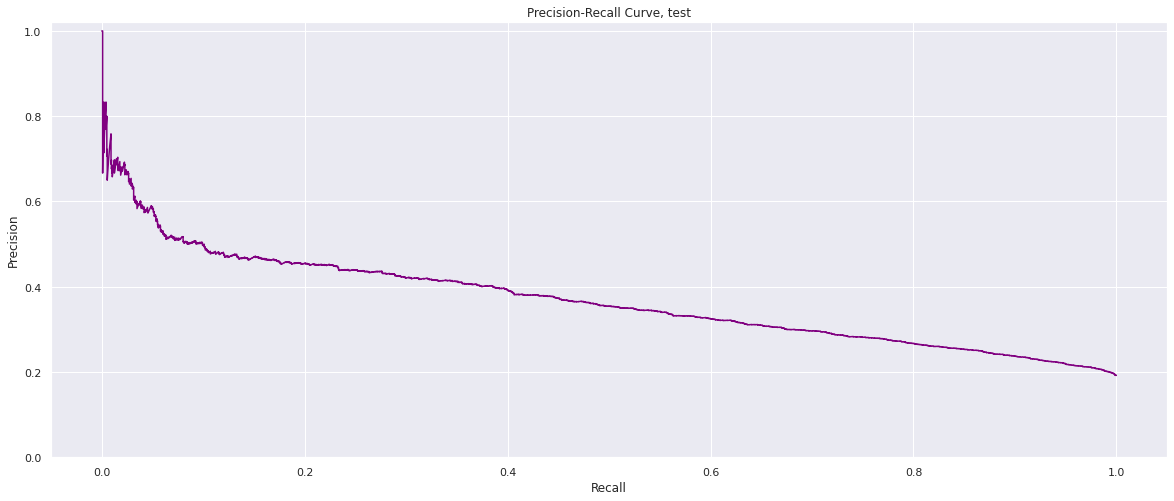

In [104]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

In [ ]:
### Fit XGBoost using Optuna hyperparameter optimization ###

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=1):

    cv_regularizer=0.05
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 700, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.4),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
            y_pred_train[train_index] += model.predict(X_A)
        score_train = roc_auc_score(y_train, y_pred_train)
        score_test = roc_auc_score(y_train, y_pred) 
        overfit = score_train-score_test
        #return (score_test)
        #return (score_test-cv_regularizer*overfit)
        temp_out.append(score_test-cv_regularizer*overfit)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

[I 2022-08-13 03:16:49,516] A new study created in memory with name: no-name-8b2932b0-c173-4f7f-bb4c-57c43b117959
[I 2022-08-13 03:17:35,725] Trial 0 finished with value: 0.5278366475082481 and parameters: {'n_estimators': 992, 'max_depth': 8, 'learning_rate': 0.3908013642425388, 'colsample_bytree': 0.8474105880702085, 'subsample': 0.6549511613107055, 'alpha': 0.12184595010818364, 'lambda': 10.323363038631381, 'gamma': 0.003141888860848514, 'min_child_weight': 0.10894152101560131}. Best is trial 0 with value: 0.5278366475082481.
[I 2022-08-13 03:17:48,644] Trial 1 finished with value: 0.5425595493193753 and parameters: {'n_estimators': 911, 'max_depth': 4, 'learning_rate': 0.25811204989062825, 'colsample_bytree': 0.8020040779278015, 'subsample': 0.7635887803091181, 'alpha': 9.13542289965615, 'lambda': 1.2286408450694875, 'gamma': 3.458245314911986e-09, 'min_child_weight': 3.1728608550952107}. Best is trial 1 with value: 0.5425595493193753.
[I 2022-08-13 03:18:04,353] Trial 2 finished w

In [ ]:
results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
fi = fi.sort_values('FI', ascending = False)

display(fi[:30])

In [ ]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
display(feature_importance[:30])

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)

shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [ ]:
# error analysis
y_pred = optuna_xgb.predict_proba(X_test)[:, 1]
error_df = test0.copy()
error_df['truth'] = y_test
error_df['pred'] = y_pred
error_df['error'] = error_df.pred - error_df.truth
error_df

In [ ]:
display(error_df[['truth', 'pred']].describe(),error_df[error_df.error<-0.97])

In [ ]:
indx = 9506
fig = plt.subplots(figsize=(6,6),dpi=200)
ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

In [ ]:
shap.initjs()
shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

In [ ]:
error_df[['pred','truth']].describe()

In [ ]:
time.time()-time0